https://arxiv.org/pdf/1609.02907.pdf

https://arxiv.org/pdf/1611.07308.pdf

https://arxiv.org/pdf/2009.03294.pdf

## Imports

In [1]:
import os
import sys
import random
import pickle
import multiprocessing
import gc; gc.enable()
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm

from openbabel import pybel

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torch_geometric
from torch_geometric.data import Data as GraphData
from torch_geometric.loader import DataLoader as GraphDataLoader

## SMILES from PubChem

In [2]:
data = pd.read_csv('./data/PubChem_compound_list_3Zp66bdu0tLl_Frl2J0TySfder3kFKFH22K6C8BzqArAapQ.csv',
                   usecols=['isosmiles'])
data.columns = ['Smiles']

## Process SMILES to obtain atoms/bonds data

In [3]:
def process_smiles(smiles):
    try:
        mol = pybel.readstring('smi', smiles)
        mol.addh()
        mol = mol.OBMol
        num_atoms, num_bonds = mol.NumAtoms(), mol.NumBonds()

        atoms = np.zeros(num_atoms, dtype=object)
        bonds = np.zeros((num_bonds, 2), dtype=int)
        orders = np.zeros(num_bonds, dtype=int)

        for index in range(num_atoms):
            atom = mol.GetAtomById(index)
            atoms[index] = atom.GetType()

        for index in range(num_bonds):
            bond = mol.GetBond(index)
            bonds[index] = [bond.GetBeginAtom().GetId(), bond.GetEndAtom().GetId()]
            orders[index] = bond.GetBondOrder()

        return atoms, bonds, orders, smiles
    
    except:
        return None, None, None, None

In [4]:
smiles_list_all = data['Smiles'].values

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
tmp = pool.map(process_smiles, tqdm(smiles_list_all))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 25928.16it/s]


In [5]:
mask = [(item[1] is not None and len(item[1]) > 0 and len(item[0]) < 128) for item in tqdm(tmp)]

atoms_list = [item[0] for item, flag in zip(tqdm(tmp), mask) if flag]
bonds_list = [item[1] for item, flag in zip(tqdm(tmp), mask) if flag]
orders_list = [item[2] for item, flag in zip(tqdm(tmp), mask) if flag]
smiles_list = [item[3] for item, flag in zip(tqdm(tmp), mask) if flag]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 2368656.99it/s]


In [6]:
#import pickle
#pickle.dump((atoms_list, bonds_list, orders_list, smiles_list), open('data.pkl', 'wb'))

In [7]:
#import pickle
#atoms_list, bonds_list, orders_list, smiles_list = pickle.load(open('data.pkl', 'rb'))

## Create atoms dictionary and build graphs

In [8]:
dictionary = set()
for item in tqdm(atoms_list):
    dictionary = dictionary.union(set(item))
    
counts = {item: 0 for item in dictionary}
for item in tqdm(atoms_list):
    for jtem in item:
        counts[jtem] += 1
        
dictionary, index = dict(), 0
for key, value in counts.items():
    if value < 10000:
        continue
    dictionary[key] = index
    index += 1
dictionary['UNK'] = index
dictionary

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4043/4043 [00:00<00:00, 124985.78it/s]


{'H': 0, 'Car': 1, 'C3': 2, 'UNK': 3}

In [9]:
def build_graph(atoms, bonds, orders, dictionary):
    x = np.asarray([dictionary[atom] if atom in dictionary.keys() else dictionary['UNK'] for atom in atoms],
                   dtype=np.int64)    

    edge_index = np.zeros((2, len(bonds)), dtype=np.int64)
    for index, (bond, order) in enumerate(zip(bonds, orders)):
        edge_index[:, index] = bond
        
    return GraphData(x=torch.LongTensor(x), edge_index=torch.LongTensor(edge_index))


#pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
#graphs = pool.map(lambda index: build_graph(atoms_list[index],
#                                            bonds_list[index],
#                                            orders_list[index],
#                                            dictionary), tqdm(np.arange(len(atoms_list))))

graphs = [build_graph(atoms_list[index],
                      bonds_list[index],
                      orders_list[index],
                      dictionary) for index in tqdm(np.arange(len(atoms_list)))]
random.shuffle(graphs)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4043/4043 [00:00<00:00, 10442.81it/s]


## (Optional: dump or load dictionary and graphs)

In [10]:
#pickle.dump(dictionary, open('dictionary.pkl', 'wb'))
#pickle.dump(graphs, open('graphs.pkl', 'wb'))

#dictionary = pickle.load(open('dictionary.pkl', 'rb'))
#graphs = pickle.load(open('graphs.pkl', 'rb'))

## VGAE Encoder

In [11]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, dict_size, out_channels, depth):
        super(VariationalGCNEncoder, self).__init__()
        self.emb = nn.Embedding(dict_size, out_channels)
        self.convs = nn.ModuleList([nn.Sequential(torch_geometric.nn.GCNConv(out_channels, out_channels),
                                                  torch_geometric.nn.GraphConv(out_channels, out_channels))
                                    for _ in range(depth)])
        self.conv_mu = torch_geometric.nn.GCNConv(out_channels, out_channels)
        self.conv_logstd = torch_geometric.nn.GCNConv(out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.emb.forward(x)
        for conv in self.convs:
            x = conv[0].forward(x, edge_index)
            x = conv[1].forward(x, edge_index)
            x = torch.relu(x)
        return self.conv_mu.forward(x, edge_index), self.conv_logstd.forward(x, edge_index)

## Engine

In [12]:
def iterate_loader(model, opt, scheduler, graphs, epoch, writer, path_to_save,
                   aggregate=128, delta=1024, device=torch.device('cuda:0')):
    def build_neg_edges(x, edge_index):
        tmp = edge_index.numpy()
        edge_index_set = set([(tmp[0, index], tmp[1, index]) for index in range(tmp.shape[1])])
        result = []
        for index in range(len(x)):
            for jndex in range(index + 1, len(x)):
                if (index, jndex) not in edge_index_set:
                    result.append([index, jndex])
        return torch.LongTensor(np.asarray(result).T)

    losses, aucs = [], []
    losses_mean, aucs_mean = [], []
    for index, batch in enumerate(tqdm(graphs, desc=str(epoch) + ' epoch')):
        x, edge_index = batch.x, batch.edge_index
        neg_edge_index = build_neg_edges(x, edge_index)
        if len(neg_edge_index) == 0:
            continue
        x, edge_index, neg_edge_index = x.to(device), edge_index.to(device), neg_edge_index.to(device)
        
        with torch.no_grad():
            model.train(False)
            z = model.encode(x, edge_index)
            auc, _ = model.test(z, edge_index, neg_edge_index)
            aucs.append(auc)

        model.train(True)
        z = model.encode(x, edge_index)
        loss = model.recon_loss(z, edge_index)
        loss = loss + (1 / x.shape[0]) * model.kl_loss()

        losses.append(loss.detach().cpu().numpy())        
        loss.backward()
        
        if (index + 1) % aggregate == 0:
            opt.step()
            opt.zero_grad()
            if scheduler is not None:
                scheduler.step()

        if (index + 1) % delta == 0 or (index + 1) == len(graphs):
            losses_mean.append(np.mean(losses[-delta:]))
            aucs_mean.append(np.mean(aucs[-delta:]))
            
            writer.add_scalar('loss', losses_mean[-1], index)
            writer.add_scalar('auc', aucs_mean[-1], index)
            writer.flush()
            
            torch.save(model.state_dict(), path_to_save) 
            
            clear_output()
            
            plt.figure(figsize=(8, 4))
            plt.plot(losses_mean)
            plt.title('last loss: ' + str(losses_mean[-1]))
            plt.xlabel('loss')
            plt.grid()
            plt.show()
            
            plt.figure(figsize=(8, 4))
            plt.plot(aucs_mean)
            plt.title('last auc: ' + str(aucs_mean[-1]))
            plt.xlabel('auc')
            plt.grid()
            plt.show()

    losses, aucs = np.asarray(losses), np.asarray(aucs)
    return losses, aucs

## Args

In [13]:
exp_name = 'test'
device = torch.device('cuda:0')

aggregate, delta, num_workers = 128, 1024, 8
num_epochs, lr, gamma = 1, 1e-4, 0.9997

model_width, model_depth = 128, 16

## Launch

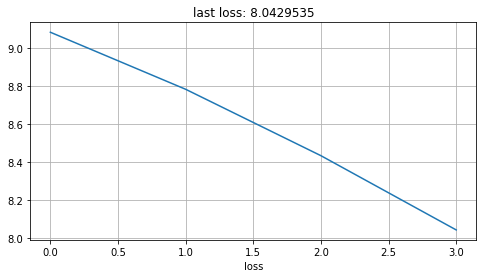

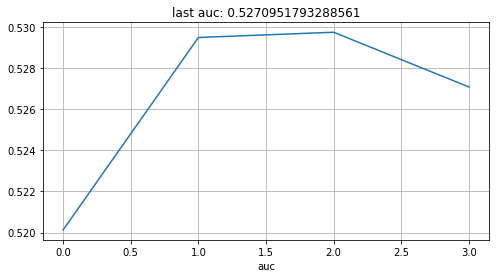

2 epoch: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4043/4043 [03:03<00:00, 22.09it/s]


In [14]:
model = torch_geometric.nn.VGAE(VariationalGCNEncoder(len(dictionary), model_width, model_depth))
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=gamma)

writer = SummaryWriter(log_dir=os.path.join('./logs', exp_name))
path_to_save = os.path.join('./ckpt', exp_name + '.pth')
os.makedirs('./ckpt', exist_ok=True)

for epoch in range(num_epochs):
    losses, aucs = iterate_loader(model, opt, scheduler, graphs, epoch + 1,
                                  writer, path_to_save,
                                  aggregate=aggregate, delta=delta, device=device)
writer.close()